In [2]:
import cv2
import numpy as np
import glob
import pickle
from tracker import tracker
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [3]:
calibFile = 'calibration_pickle.p'
camerCalib = pickle.load(open(calibFile,'rb'))

mtx = camerCalib["mtx"]
dist = camerCalib["dist"]

In [4]:
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary) == 1] = 1

    # Return the combined s_channel & v_channel binary image
    return output

def s_channel_threshold(image, sthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]  # use S channel

    # create a copy and apply the threshold
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    return binary_output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), 
           max(0,int(center-width)):min(int(center+width),img_ref.shape[1])] = 1
    #print ("Level {}, mask Slice {}: ".format(level, (int(img_ref.shape[0]-(level+1.5)*height), int(img_ref.shape[0]-level*height), 
           #max(0,int(center-width)), min(int(center+width),img_ref.shape[1]))))
    return output

import numba as nb # for fast looping through image array
@nb.njit()
def remove_nonLaneLine(T, image_data):
    # grab the image dimensions
#     maskImg = np.copy(image_data)
#     for y in range(0,image_data.shape[0]):
#         for x in range(0,image_data.shape[1]):
#             # threshold the pixel
#             if maskImg[y, x] <= T:
#                 maskImg[y, x] = 255 
#             else:
#                 maskImg[y, x] = 0  
    thresh1 = cv2.threshold(image_data, 50, 255, cv2.THRESH_BINARY)
    return thresh1

In [4]:
fname = './test_img/error.jpg'
img = cv2.imread(fname)
#undistort the image
img = cv2.undistort(img,mtx,dist,None,mtx)

#pass image thru the pipeline
preprocessImage = np.zeros_like(img[:,:,0])
gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imgInv = cv2.bitwise_not(gray_img) #invert the image
c_binary = remove_nonLaneLine(70, imgInv) #mask non-lane center line by thresholding
preprocessImage[((gradx == 1) & (grady ==1) & (c_binary >= 1))] = 255
# c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
# preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

img_size = (img.shape[1],img.shape[0])

bot_width = .76 # percentage of bottom trapezoidal height
mid_width = .08 # percentage of mid trapezoidal height
height_pct = .495 # percentage of trapezoidal height
bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

src = np.float32([[img.shape[1]*(0.528-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.535+mid_width/2),img.shape[0]*height_pct],
                  [img.shape[1]*(0.475+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.345-bot_width/2), img.shape[0]*bottom_trim]])
offset = img_size[0]*0.25
dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])

M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)

window_width = 45
window_height = 95

#set up the overall class to do the lane line tracking
curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 5, 
                        My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=10)

window_centroids = curve_centers.find_window_centroids(warped)
window_centroids

array([[237.5, 705.5],
       [237.5, 703.5],
       [234.5, 700.5],
       [229.5, 701.5],
       [233.5, 702.5]])

Level 0, mask Slice (472, 540, 82, 152): 
Level 0, mask Slice (472, 540, 815, 885): 
Level 1, mask Slice (427, 495, 57, 127): 
Level 1, mask Slice (427, 495, 806, 876): 
Level 2, mask Slice (382, 450, 32, 102): 
Level 2, mask Slice (382, 450, 818, 888): 
Level 3, mask Slice (337, 405, 7, 77): 
Level 3, mask Slice (337, 405, 830, 900): 
Level 4, mask Slice (292, 360, 0, 52): 
Level 4, mask Slice (292, 360, 851, 921): 
Level 5, mask Slice (247, 315, 0, 27): 
Level 5, mask Slice (247, 315, 864, 934): 
Level 6, mask Slice (202, 270, 0, 51): 
Level 6, mask Slice (202, 270, 880, 950): 
Level 7, mask Slice (157, 225, 0, 46): 
Level 7, mask Slice (157, 225, 893, 960): 
Level 8, mask Slice (112, 180, 0, 25): 
Level 8, mask Slice (112, 180, 906, 960): 
Level 9, mask Slice (67, 135, 0, 17): 
Level 9, mask Slice (67, 135, 906, 960): 
Level 10, mask Slice (22, 90, 0, 17): 
Level 10, mask Slice (22, 90, 881, 951): 
Level 11, mask Slice (-22, 45, 0, 17): 
Level 11, mask Slice (-22, 45, 877, 947): 


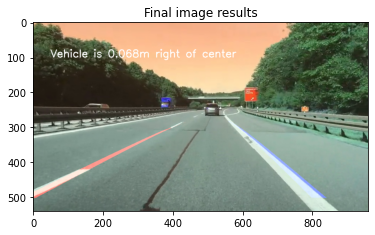

True

In [9]:
gidx=0


#read in image
img = cv2.imread(fname)
#undistort the image
img = cv2.undistort(img,mtx,dist,None,mtx)

preprocessImage = np.zeros_like(img[:,:,0])
gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imgInv = cv2.bitwise_not(gray_img) #invert the image
c_binary = remove_nonLaneLine(70, imgInv) #mask non-lane center line by thresholding
preprocessImage[((gradx == 1) & (grady ==1) & (c_binary >= 1))] = 255

# c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
# preprocessImage[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255

img_size = (img.shape[1],img.shape[0])

bot_width = .76 # percentage of bottom trapezoidal height
mid_width = .08 # percentage of mid trapezoidal height
height_pct = .525 # percentage of trapezoidal height
bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

src = np.float32([[img.shape[1]*(0.522-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.530+mid_width/2),img.shape[0]*height_pct],
                  [img.shape[1]*(0.475+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.38-bot_width/2), img.shape[0]*bottom_trim]])
offset = img_size[0]*0.15
dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])   

#perform the warp perspective transform
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(preprocessImage, M, img_size, flags=cv2.INTER_LINEAR)

window_width = 35
window_height = 45

#set up the overall class to do the lane line tracking
curve_centers = tracker(Mywindow_width=window_width, Mywindow_height=window_height, Mymargin = 25, 
                        My_ym = 10/720, My_xm = 4/384, Mysmooth_factor=15)

window_centroids = curve_centers.find_window_centroids(warped)

# Points used to draw all the left and right windows
l_points = np.zeros_like(warped)
r_points = np.zeros_like(warped)

# points used to find the right & left lanes
rightx = []
leftx = []

# Go through each level and draw the windows 
for level in range(0,len(window_centroids)):
    # Window_mask is a function to draw window areas
    # Add center value found in frame to the list of lane points per left, right
    leftx.append(window_centroids[level][0])
    rightx.append(window_centroids[level][1])

    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
    # Add graphic points from window mask here to total pixels found 
    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

# Draw the results
template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
zero_channel = np.zeros_like(template) # create a zero color channel
template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the original road image with window results

#fit the lane boundaries to the left, right center positions found
yvals = range(0,warped.shape[0])

res_yvals = np.arange(warped.shape[0]-(window_height/2),0,-window_height)

left_fit = np.polyfit(res_yvals, leftx, 2)
left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
left_fitx = np.array(left_fitx,np.int32)

right_fit = np.polyfit(res_yvals, rightx, 2)
right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
right_fitx = np.array(right_fitx,np.int32)

left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2),axis=0),
                              np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),
                               np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)
middle_marker = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2),axis=0),np.concatenate((yvals,yvals[::-1]),axis=0))),np.int32)

road = np.zeros_like(img)
road_bkg = np.zeros_like(img)
cv2.fillPoly(road,[left_lane],color=[255,0,0])
cv2.fillPoly(road,[right_lane],color=[0,0,255])
cv2.fillPoly(road_bkg,[left_lane],color=[255,255,255])
cv2.fillPoly(road_bkg,[right_lane],color=[255,255,255])

road_warped = cv2.warpPerspective(road,Minv,img_size,flags=cv2.INTER_LINEAR)
road_warped_bkg= cv2.warpPerspective(road_bkg,Minv,img_size,flags=cv2.INTER_LINEAR)

base = cv2.addWeighted(img,1.0,road_warped, -1.0, 0.0)
result = cv2.addWeighted(base,1.0,road_warped, 1.0, 0.0)
ym_per_pix = curve_centers.ym_per_pix # meters per pixel in y dimension
xm_per_pix = curve_centers.xm_per_pix # meters per pixel in x dimension

curve_fit_cr = np.polyfit(np.array(res_yvals,np.float32)*ym_per_pix,np.array(leftx,np.float32)*xm_per_pix,2)
curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) /np.absolute(2*curve_fit_cr[0])

# Calculate the offset of the car on the road
camera_center = (left_fitx[-1] + right_fitx[-1])/2
center_diff = (camera_center-warped.shape[1]/2)*xm_per_pix
side_pos = 'left'
if center_diff <= 0:
    side_pos = 'right'

# draw the text showing curvature, offset & speed
#cv2.putText(result, 'Radius of Curvature='+str(round(curverad,3))+'m ',(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
cv2.putText(result, 'Vehicle is '+str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

# plt.imshow(result, cmap='gray')
# plt.title('Final image results')
# plt.show()

cv2.imshow("ROI", warptrap)
cv2.imwrite("ROI.jpg", warptrap)
cv2.waitKey(0)

write_name='./test_images/tracked'+'.jpg'
cv2.imwrite(write_name, result)

In [10]:
cv2.imshow("Result", result)
cv2.waitKey(0)

-1

In [6]:
def canny_edge_detection(img):
#     G_Blur_img = cv2.GaussianBlur(img,(3,3), 0.6)
    canny_edges = cv2.Canny(img, 30, 120)
    return canny_edges

In [53]:
cap = cv2.VideoCapture('Lane_video.mp4')
if (cap.isOpened() == False):  
    print("Error reading video file") 
frame_width = int(cap.get(3))
frame_height = int(cap.get(4)) 
size = (frame_width, frame_height)
# save video in .avi format at 35fps
result = cv2.VideoWriter('Lane_detect_Binary_Preprocessed.avi', cv2.VideoWriter_fourcc(*'XVID'), 35.0,size)

while(1): 
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    imgInv = cv2.bitwise_not(gray_img) #invert the image
    ret, thresh1 = cv2.threshold(imgInv, 60, 255, cv2.THRESH_BINARY_INV)
    #expImg_Inv = cv2.bitwise_and(imgInv,ThresImg) # remove non-lane center line by and with invertedImg
    canny_img = canny_edge_detection(thresh1) # detect canny edges
#     Lines = [(400,300),# Top-left corner 
#               (0, 500), # Bottom-left corner            
#               (900,540), # Bottom-right corner
#               (580,275)] # Top-right corner
#     height,width = frame.shape[:2]
#     lines = [(0,height),(920,height),(400,250)]
#     roi_img = region_of_interest(canny_img,Lines)# crops roi from lane image
#     houghLines = cv2.HoughLinesP(roi_img, 3, np.pi/180, 40,None, 20, 45) #returs list of line in the frame
#     avg_lines = average_slope_intercept (frame,houghLines) # Avg all the lines in the frame
#     lines_img = display_lines(frame,avg_lines) # plots lane tracking line on the frame
    result.write(canny_img)  # save frame
    cv2.imshow("ImageRegion", canny_img)     
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
result.release() 
cv2.destroyAllWindows()

No frames grabbed!


In [62]:
def process_image_binary(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgInv = cv2.bitwise_not(gray_img) #invert the image
    ret, thresh1 = cv2.threshold(gray_img, 55, 255, cv2.THRESH_BINARY)
    canny_img = canny_edge_detection(gray_img) 
    binaryImage = np.copy(img)
    binaryImage = np.array(cv2.merge((canny_img,canny_img,canny_img)),np.uint8) # Output Must be 3 channel Img
    return binaryImage

In [63]:
from moviepy.editor import VideoFileClip
Output_video = 'Lane_detect_Binary_No_Preprocessed.mp4'
Input_video = 'Lane_video.mp4'
#Output_video = 'output_challenge_video.mp4'
#Input_video = 'harder_challenge_video.mp4'
#Output_video = 'output_challenge_video.mp4'
#Input_video = 'challenge_video.mp4'

clip1 = VideoFileClip(Input_video)
video_clip = clip1.fl_image(process_image_binary) # This function expects 3 channel images and add return Img
video_clip.write_videofile(Output_video, audio=False)

t:   3%|█▋                                                                  | 10/390 [00:00<00:04, 91.15it/s, now=None]

Moviepy - Building video Lane_detect_Binary_No_Preprocessed.mp4.
Moviepy - Writing video Lane_detect_Binary_No_Preprocessed.mp4



Moviepy - Done !
Moviepy - video ready Lane_detect_Binary_No_Preprocessed.mp4


In [7]:
fname = './test_img/error.jpg'
img = cv2.imread(fname)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgInv = cv2.bitwise_not(gray_img) #invert the image
ret, thresh1 = cv2.threshold(imgInv, 65, 255, cv2.THRESH_BINARY_INV)
canny_img = canny_edge_detection(thresh1) # detect canny edges
cv2.imshow("imgInv", imgInv)
cv2.imwrite("imgInv.jpg", imgInv)
cv2.imshow("BinaryImage", thresh1)
cv2.imwrite("BinaryImage.jpg", thresh1)
cv2.waitKey(0)

-1

In [8]:
fname = './test_img/error.jpg'
img = cv2.imread(fname)

img_size = (img.shape[1],img.shape[0])

bot_width = .76 # percentage of bottom trapezoidal height
mid_width = .08 # percentage of mid trapezoidal height
height_pct = .52 # percentage of trapezoidal height
bottom_trim= .935 # percentage from top to bottom avoiding the hood of the car

src = np.float32([[img.shape[1]*(0.522-mid_width/2), img.shape[0]*height_pct],[img.shape[1]*(0.530+mid_width/2),img.shape[0]*height_pct],
                  [img.shape[1]*(0.475+bot_width/2), img.shape[0]*bottom_trim],[img.shape[1]*(0.38-bot_width/2), img.shape[0]*bottom_trim]])
offset = img_size[0]*0.14
dst = np.float32([[offset,0],[img_size[0]-offset,0],[img_size[0]-offset,img_size[1]],[offset,img_size[1]]])

warptrap = np.copy(img)
cv2.line(warptrap, (int(src[0][0]), int(src[0][1])), (int(src[1][0]), int(src[1][1])), [255,0,0], 10, cv2.LINE_AA)
cv2.line(warptrap, (int(src[1][0]), int(src[1][1])), (int(src[2][0]), int(src[2][1])), [255,0,0], 10, cv2.LINE_AA)
cv2.line(warptrap, (int(src[2][0]), int(src[2][1])), (int(src[3][0]), int(src[3][1])), [255,0,0], 10, cv2.LINE_AA)
cv2.line(warptrap, (int(src[3][0]), int(src[3][1])), (int(src[0][0]), int(src[0][1])), [255,0,0], 10, cv2.LINE_AA)
cv2.imshow("ROI", warptrap)
cv2.imwrite("ROI.jpg", warptrap)
cv2.waitKey(0)

-1